# 02.2B Clasificación naive-Bayes de  fronteras intron-exón o exón-intrón de un conjunto de secuencias de DNA (SOLUCIÓN)



## "Corta-pega" en RNA:

- En algunos genes, las secciones del DNA que codifican proteínas (__exones__) a veces están interrumpidas por regiones no
codificantes (__intrones__).

- El proceso de "corta-pega" del RNA __quita los intrones__ del mRNA para generar la secuencia final que codifica la proteina, dejando únicamente los exones en el RNA editado. Los intrones vienen caracterizados por un sitio __donor__ (frontera exón-intrón) y uno __aceptor__ (frontera intrón-exón).

Una animación del proceso se muestra en: https://dnalc.cshl.edu/resources/3d/rna-splicing.html

### Problema 
¿__a partir de una lista de secuencias de DNA de las que conocemos "sitios donores", ¿podemos predecir los sitios donores en nuevas secuencias__?

## Conjunto de datos de entrenamiento
El conjunto de datos esta en el archivo 'splice.txt' que puedes descargar de Moodle. Las primeras líneas del archivo son (hemos truncado las ultimas posiciones de las secuencias solo para ajustarlas al texto de este documento):

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/splice.txt')
df.head()

Class            Instance                                           Sequence
0    EI    ATRINS-DONOR-521  CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1    EI    ATRINS-DONOR-905  AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2    EI    BABAPOE-DONOR-30  GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3    EI   BABAPOE-DONOR-867  GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4    EI  BABAPOE-DONOR-2817  GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...

Todas las secuencias tienen 60 pares de bases. La primera columna (__Class__) indica la clase a la que pertenece la secuencia: EI para las que proporcionan un salto exon-intrón (donores); IE para las secuencias que contienen una frontera intron-exón (aceptores); N para aquellas secuencias que no son ni EI ni IE. 

La segunda columna (__Instance__) es una etiqueta para cada una de las instancias (filas), y la tercera columna da la __secuencia__ correspondiente en terminos del alfabeto A, T, C y G.

## Preproceso de las secuencias

Algunas de las secuencias tienen ambiguedad en determinadas posiciones, de forma que incluyen las letras D, N, S o R de acuerdo con la siguiente tabla:

| Letra | Significado |
| ----- | ------- |
| D | A o G o T |
| N | A o G o T o C |
| S | C o G |
| R | A o G |

Estos caracteres ambiguos aparecen en muy pocas instancias, así que se van a eliminar de los datos para simplificar el analisis. Primero se realiza un proceso de filtrado para saber cuantas secuencias quedan:


In [2]:
df['Sequence'].str.contains("D|N|S|R").value_counts()

False    3175
True       15
Name: Sequence, dtype: int64

In [3]:
df[df['Sequence'].str.contains("D|N|S|R")]

Class                 Instance  \
107     EI        HUMALPI1-DONOR-42   
239     EI       HUMCSPB-DONOR-2010   
365     EI        HUMH19-DONOR-2562   
366     EI        HUMH19-DONOR-2766   
485     EI     HUMMHCD8A-DONOR-1087   
1247    IE  HUMMHB27B-ACCEPTOR-1202   
1440    IE    HUMSPRO-ACCEPTOR-2841   
1441    IE    HUMSPRO-ACCEPTOR-3195   
1804     N         HUMC1A1-NEG-3901   
2069     N           HUMFERG2-NEG-1   
2135     N          HUMGCB-NEG-2281   
2578     N       HUMMHB27B-NEG-1201   
2636     N        HUMMHDRR2-NEG-121   
2637     N        HUMMHDRS1-NEG-241   
2910     N        HUMRSCNTT-NEG-121   

                                               Sequence  
107   CACACAGGGCACCCCCTCANNNNNNNNNNNNNNNNNNNNNNNNNNN...  
239   AACTTCTCCAACGACATCATGCTACTGCAGGTNAGGCACACTCCTG...  
365   TCTGGGCTCCCAGAACCCACAACATGAAAGGTGAGGGNCTTCCTGC...  
366   ACTACCTGACTCAGGAATCGGCTCTGGAAGGTGAGCACCAGCGCTC...  
485   TCAGCCACTTCGTGCCGGTCTTCCTGCCAGGTCCGCGCGCCGGGTT...  
1247  DGACGGGGCTGACCGCGGGGGCGGGTCCAGGGTCTCACACCCTCCA...  
1440  ATACCCCTTTTCACTTTCCCCACCTCTTAGGGTARTCAGTACTGGC...  
1441  CCCTCCTAATGCCCACCATCCCGTCCTCAGGGAAASAGTACTGGGA...  
1804  ATGGCCTACATGGGTGTGGGTGCTGCAATTTCCGCTNCGGCAGACA...  
2069  GGATCCCTAGTATAACACATTCAGTGTTCCCCNTTTCAGCCCNTTT...  
2135  TGTGAACATGCGCTGTGTGCTGCTTGCTTTGGAAACTNGCCTGGGT...  
2578  GDGACGGGGCTGACCGCGGGGGCGGGTCCAGGGTCTCACACCCTCC...  
2636  TAAATCCTCTCGCTGCGTGGTGAGAAAACTGATGCCTNGAGTCTGT...  
2637  AAAATACAAAAATTAGCCNNNGGGAGGCCGAGATTACAATGAGCTG...  
2910  TGAGGTTAAAGGTNGAAAAGGAAATATCTTCGTATAAAAACTAGAC...

Finalmente se __borran__ los registros de secuencia ambigua

_Nota_: Hay que recordar que en una lista de datos con con _true_ se copian y ~(Alt-126 o insertar símbolo) niega.

In [4]:
df = df[~df['Sequence'].str.contains("D|N|S|R")]
df

Class            Instance  \
0       EI    ATRINS-DONOR-521   
1       EI    ATRINS-DONOR-905   
2       EI    BABAPOE-DONOR-30   
3       EI   BABAPOE-DONOR-867   
4       EI  BABAPOE-DONOR-2817   
...    ...                 ...   
3185     N  ORAHBPSBD-NEG-2881   
3186     N   ORAINVOL-NEG-2161   
3187     N     ORARGIT-NEG-241   
3188     N      TARHBB-NEG-541   
3189     N     TARHBD-NEG-1981   

                                               Sequence  
0     CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...  
1     AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...  
2     GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...  
3     GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...  
4     GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...  
...                                                 ...  
3185  TCTCTTCCCTTCCCCTCTCTCTTTCTTTCTTTTCTCTCCTCTTCTC...  
3186  GAGCTCCCAGAGCAGCAAGAGGGCCAGCTGAAGCACCTGGAGAAGC...  
3187  TCTCGGGGGCGGCCGGCGCGGCGGGGAGCGGTCCCCGGCCGCGGCC...  
3188  ATTCTACTTAGTAAACATAATTTCTTGTGCTAGATAACCAAATTAA...  
3189  AGGCTGCCTATCAGAAGGTGGTGGCTGGTGTGGCTGCTGCTCTGGC...  

[3175 rows x 3 columns]

### Obtener dos subconjuntos, uno de entrenamiento y otro de validación

Divide el conjunto de datos en una parte para entrenamiento y otra parte para validacion, empleando muestreo aleatorio sin repetición. Reserva un 70 % de las instancias para entrenamiento y un 30 % para el conjunto de validacion

In [5]:
from sklearn.model_selection import train_test_split
X, y = df.values[:,2], df.values[:,0]
X_train, X_test, y_train, y_test =train_test_split(X, y, train_size=0.7, random_state=0, stratify=y, shuffle=True)

## Implementación con la librería sk-learn

### Primero se prepara la matriz X de los conjuntos de entranamiento y pruebas

Para hacer el entrenamiento hay que __convertir la cadena de 60 caracteres en 60 caracteristicas de 1 caracter__:

In [9]:
X_train60 = [[letra for letra in fila] for fila in X_train]
X_test60 = [[letra for letra in fila] for fila in X_test]
print(len(X_train60), len(X_train60[0]), len(y_train))
print(len(X_test60), len(X_test60[0]), len(y_test))

2222 60 2222
953 60 953


### Además se convierten los caracteres alfabéticos en números

__Hay varias posibilidades para hacer ésto, damos una__:

In [10]:
df = pd.DataFrame(X_train60)
bases=['A','T','C','G']
base_mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
for iCol in range(60):
    df[iCol] = df[iCol].map(base_mapping)
X_train60 = df.values

df = pd.DataFrame(X_test60)
bases=['A','T','C','G']
base_mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
for iCol in range(60):
    df[iCol] = df[iCol].map(base_mapping)
X_test60 = df.values

X_train60.shape, X_test60.shape

((2222, 60), (953, 60))

### Se Resuelve utilizando el clasificador Naive Bayes de sklearn

In [11]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
clf_NB.fit(X_train60, y_train)
tot_Test = np.size(y_test)
tot_aciertos = 0
y_pred = []
for x, y in zip(X_test60, y_test):
    y_est = clf_NB.predict([x])
    y_pred.append(y_est)
    if (y==y_est): tot_aciertos +=1
    #print('Instancia %s Clase real %s - Clase estimada %s \n' %(x, y, y_est))
print('Exactitud del clasificador (porcentaje de aciertos) = %s \n' %(tot_aciertos*100/tot_Test))

Exactitud del clasificador (porcentaje de aciertos) = 90.97586568730325 



#### Y se presenta la correspondiente matriz de confusión

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm=confusion_matrix(y_test, y_pred)
print(cm)

[[226   0   3]
 [ 29 197   3]
 [ 31  20 444]]


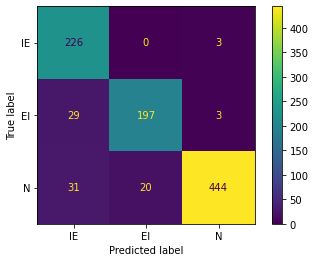

In [24]:
from sklearn.metrics import plot_confusion_matrix
clases=['IE','EI','N']
plot_confusion_matrix(clf_NB, X_test60, y_test, display_labels=clases)  